In [1]:
import os
import numpy as np
from functools import partial
import math
import time as time

import torch

M1 = False

if M1:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "2"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.ticker as tick

import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

True
1
0
NVIDIA A100-PCIE-40GB


In [2]:
# Save param
repo_dir = "./.."

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Confidence value
alpha_prob = 0.01
# Blurring Gaussian St Dev
G_sigma = 3.5

# Inpatinting params
inptaint_options = {
    "tol": 5e-6,
    "iter": 15000,
    "update_iter": 4999,
    "record_iters": False,
}

# Plotting options
cmap = "cubehelix"
cbar_font_size = 18

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 5e4
mu = 20

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "W28"
# Input noise level
input_snr = 30.0

# Prepare observations 

In [3]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1, 1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
    (1,) + img.shape
)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))

# Define likelihood and prior

In [4]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()

In [5]:
# Load CRR model
torch.set_grad_enabled(False)
# torch.set_num_threads(4)

exp_name = f"Sigma_{sigma_training}_t_{t_model}/"
if device.type == "cpu":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cpu", device_type="cpu"
    )
elif device.type == "cuda":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cuda", device_type="gpu"
    )


print(f"Numbers of parameters before prunning: {CRR_model.num_params}")
CRR_model.prune()
print(f"Numbers of parameters after prunning: {CRR_model.num_params}")

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [6]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")

Lipschitz bound 0.781


# Run optimisation algorithm anc compute the MAP reconstruction

In [7]:
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)

x_hat = qai.optim.FISTA_CRR_torch(
    x_init=x_init,
    options=options,
    likelihood=likelihood,
    prox_op=prox_op,
    CRR_model=CRR_model,
    alpha=alpha,
    lmbd=lmbd,
    mu=mu,
)

[GD] 0 out of 15000 iterations, tol = 0.102533
[GD] 100 out of 15000 iterations, tol = 0.001847
[GD] 200 out of 15000 iterations, tol = 0.000337
[GD] 300 out of 15000 iterations, tol = 0.000083
[GD] 400 out of 15000 iterations, tol = 0.000035
[GD] 500 out of 15000 iterations, tol = 0.000024
[GD] converged in 544 iterations


# Plot MAP reconstruction

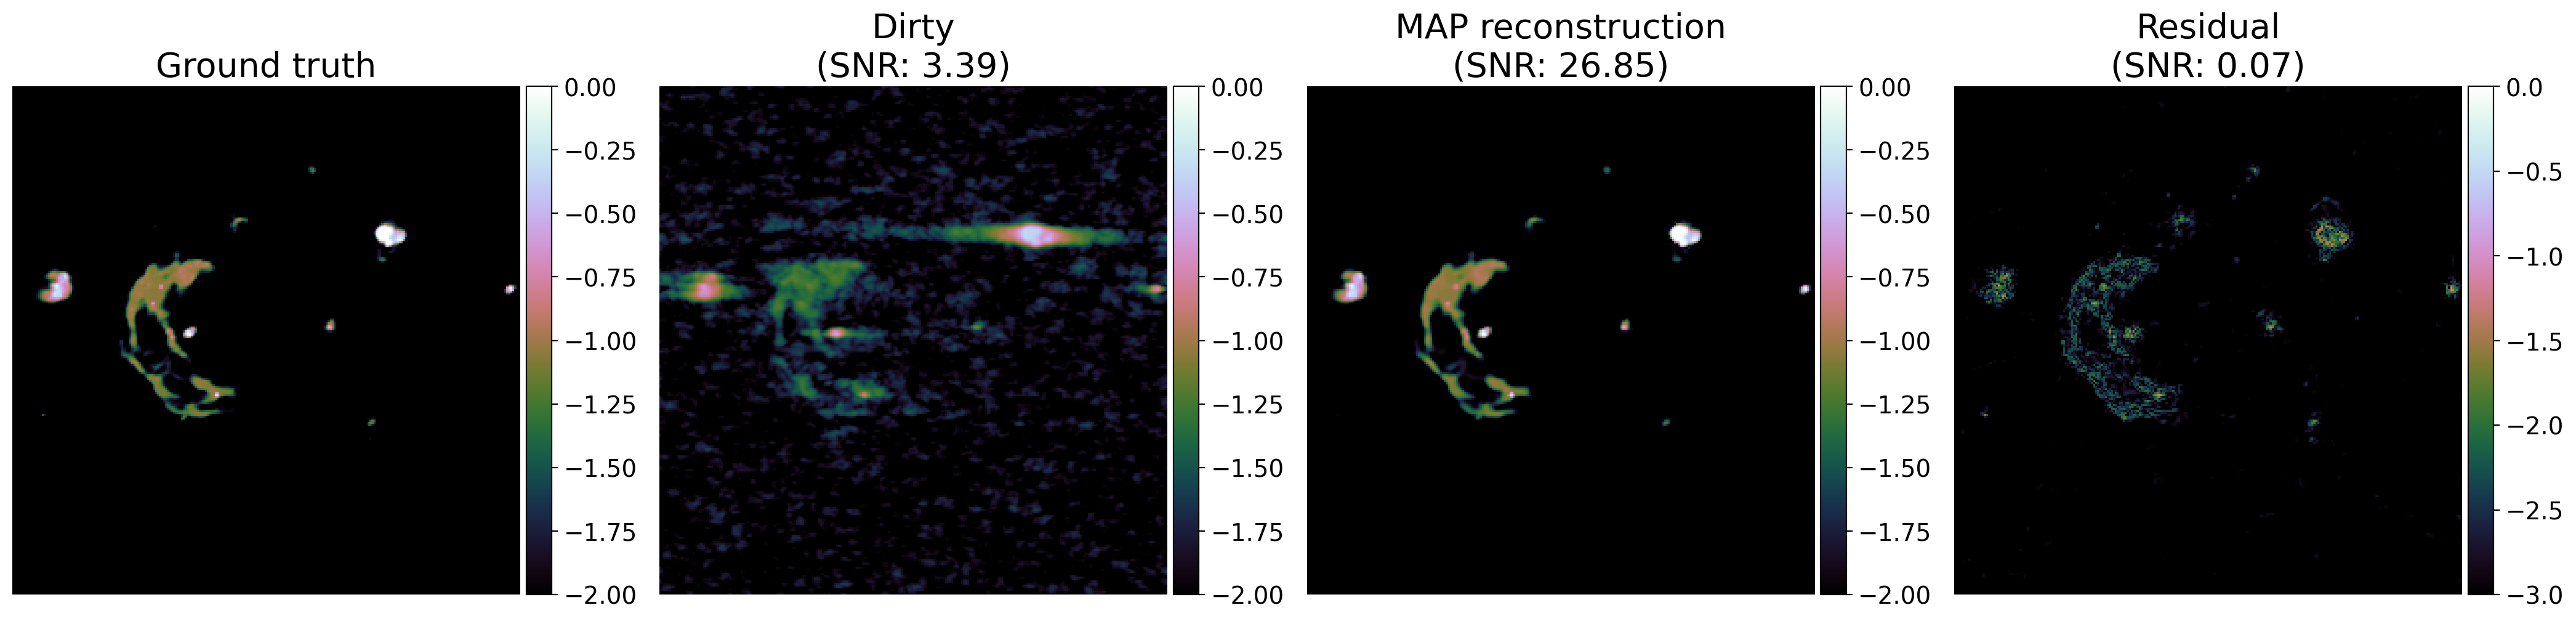

In [8]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()

# Create inpainted surrogate

### Define region to inpaint

This can be one of the default regions in `qai.helpers.get_hypothesis_test_mask()` or it can be manually defined by the user

In [9]:
x_dirty = np.copy(np_x_init)

# Define region to inpaint

# Inpainting
# Load mask details
pysiscal = True
mask_x, mask_y = qai.helpers.get_hypothesis_test_mask(img_name, pysiscal)
# Prepare mask
np_mask_inpainting = np.zeros((x_gt.shape[0], x_gt.shape[1]))
np_mask_inpainting[mask_x[0] : mask_x[1], mask_y[0] : mask_y[1]] = 1
# Prepare inpaint image
inpaint_img = np.copy(np_x_map)
inpaint_img[np_mask_inpainting.astype(bool)] = 0

mask_inpainting = to_tensor(np_mask_inpainting)
x_init_imp = to_tensor(inpaint_img)

### Plot region on top of the MAP estimation

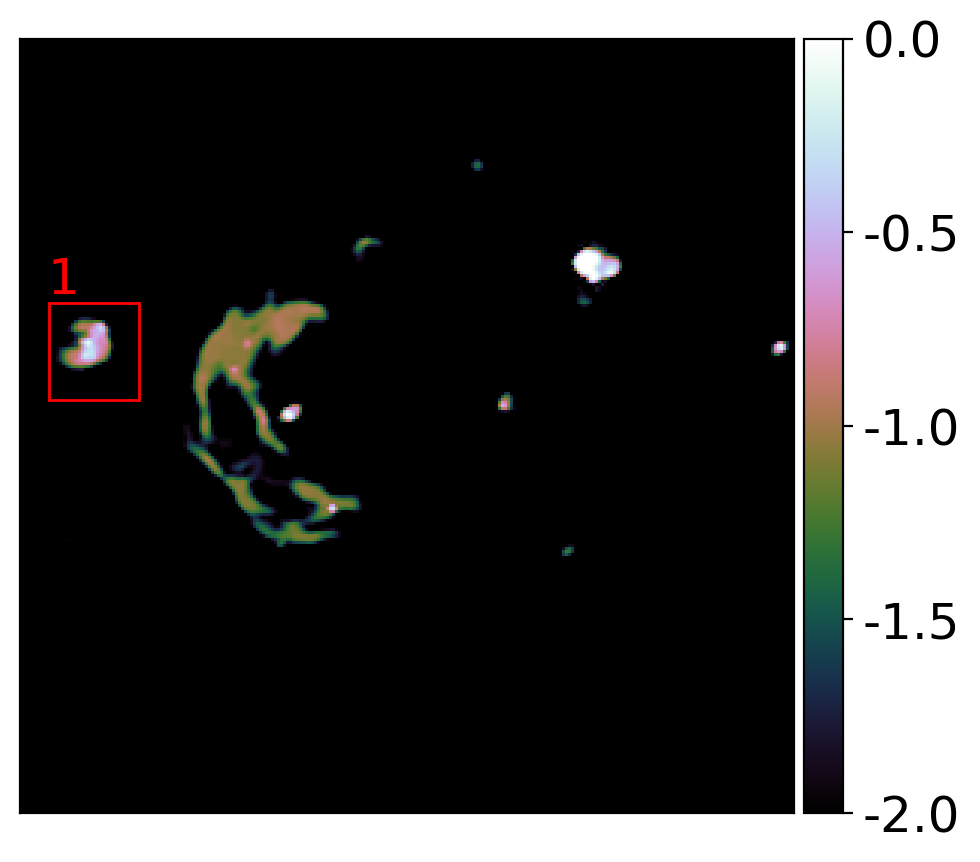

In [10]:
# Define rectangle coordinates
rect_anchor_xy = (mask_y[0], mask_x[0])
rect_width = mask_y[1] - mask_y[0]
rect_height = mask_x[1] - mask_x[0]
# Define text attributes
font = {
    "color": "red",
    "weight": "normal",
    "size": 18,
}

fig = plt.figure(figsize=(5, 5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(np.log10(np.abs(np_x_map)), cmap=cmap, vmin=-2.0, vmax=0)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter("%.1f"))
cbar.ax.tick_params(labelsize=cbar_font_size)
axs.set_yticks([])
axs.set_xticks([])
# Create a Rectangle patch
rect = patches.Rectangle(
    rect_anchor_xy,
    rect_width,
    rect_height,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
# Add the patch to the Axes
axs.add_patch(rect)
axs.text(
    rect_anchor_xy[0] / np_x_map.shape[1] + 0.0,
    1 - rect_anchor_xy[1] / np_x_map.shape[0] + 0.06,
    r"$1$",
    transform=axs.transAxes,
    fontdict=font,
    verticalalignment="top",
)
plt.tight_layout()
plt.show()

## Inpaint region


In [11]:
# To tensor
x_map_torch = x_map.clone()
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)
# initialization
x_hat = torch.clone(x_init_imp)
z = torch.clone(x_init_imp)
t = 1

for it_2 in range(inptaint_options["iter"]):
    x_hat_old = torch.clone(x_hat)

    x_hat = z - alpha * lmbd * CRR_model(mu * z)
    # Positivity constraint
    x_hat = prox_op.prox(x_hat)
    # Positivity constraint
    # x = torch.clamp(x, 0, None)

    x_hat = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map_torch) * (
        1.0 - mask_inpainting
    )

    t_old = t
    t = 0.5 * (1 + math.sqrt(1 + 4 * t**2))
    z = x_hat + (t_old - 1) / t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat) / torch.norm(x_hat_old)).item()

    if res < inptaint_options["tol"]:
        print("[GD] converged in %d iterations" % (it_2))
        break

    if it_2 % inptaint_options["update_iter"] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f"
            % (
                it_2,
                inptaint_options["iter"],
                res,
            )
        )


# Generate surrogate impainted img
surrogate_img = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map_torch) * (
    1.0 - mask_inpainting
)

imp_surrogate = to_numpy(torch.clone(surrogate_img))

[GD] 0 out of 15000 iterations, tol = 0.000102
[GD] converged in 66 iterations


### Plot inpainted surrogate image

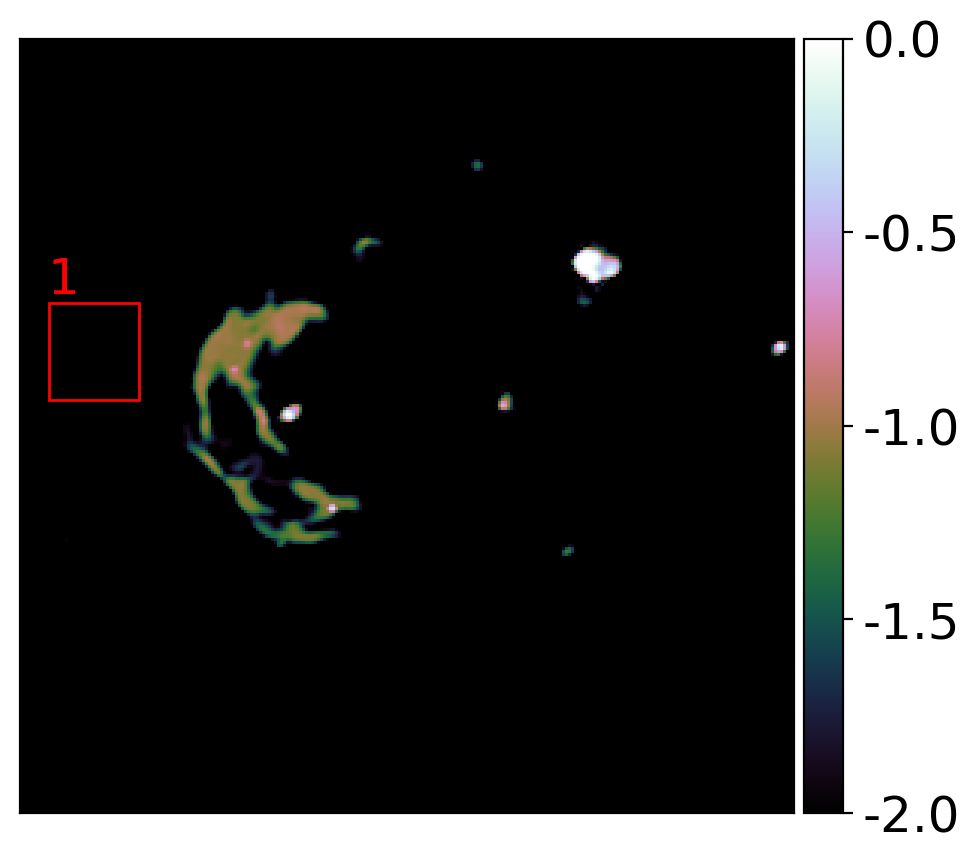

In [12]:
fig = plt.figure(figsize=(5, 5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(np.log10(np.abs(imp_surrogate)), cmap=cmap, vmin=-2.0, vmax=0)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter("%.1f"))
cbar.ax.tick_params(labelsize=cbar_font_size)
axs.set_yticks([])
axs.set_xticks([])

# Create a Rectangle patch
rect = patches.Rectangle(
    rect_anchor_xy,
    rect_width,
    rect_height,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
# Add the patch to the Axes
axs.add_patch(rect)
axs.text(
    rect_anchor_xy[0] / np_x_map.shape[1] + 0.0,
    1 - rect_anchor_xy[1] / np_x_map.shape[0] + 0.06,
    r"$1$",
    transform=axs.transAxes,
    fontdict=font,
    verticalalignment="top",
)
plt.tight_layout()

plt.show()

# Carry out the hypothesis test

### Define the potential function handles

In [13]:
# function handles for the hypothesis test
def _fun(_x, CRR_model, mu, lmbd):
    return (lmbd / mu) * CRR_model.cost(mu * _x) + likelihood.fun(_x)


# Evaluation of the potentials
fun = partial(_fun, CRR_model=CRR_model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x: fun(to_tensor(_x, dtype=myType)).item()

### Compute high posterior density (HPD) region

`gamma_alpha` corresponds to the HPD region potential threshold

In [14]:
# Compute HPD region bound
N = np_x_map.size
tau_alpha = np.sqrt(16 * np.log(3 / alpha_prob))
gamma_alpha = fun(x_map_torch).item() + tau_alpha * np.sqrt(N) + N

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


### Compute potentials and carry out hypothesis test

In [15]:
# Compute potential
map_potential = fun(x_map_torch).item()
potential = fun(surrogate_img).item()

if potential > gamma_alpha:
    print(img_name, ": Inpainted area nonremovable! (Reject H0)")
    Hnot_reject = True
else:
    print(img_name, ": Inpainted area removable! (Cannot reject H0)")
    Hnot_reject = False

# Print values
print(img_name, "_gamma_alpha: ", gamma_alpha)
print(img_name, "_surrogate_potential: ", potential)
print(img_name, "-MAP_potential: ", map_potential)

W28 : Inpainted area nonremovable! (Reject H0)
W28 _gamma_alpha:  87574.82556806403
W28 _surrogate_potential:  469933.5625
W28 -MAP_potential:  19593.248046875
